# #6 Deploy an image classification model in Azure Container Instance (ACI)

![](https://github.com/ashleymcnamara/Developer-Advocate-Bit/blob/master/bit_ai.png?raw=true)

Photo credit to the talented Ashley McNamara

#### Let's Deploy a  Computer Vision model to the Cloud using the Azure Machine Learning Service to make this simple we will revisit the MNIST dataset from the third Notebook

Based on the [Azure ML Documentation](https://docs.microsoft.com/en-us/azure/machine-learning/service/tutorial-train-models-with-aml?WT.mc_id=cvworkshop-github-abornst)

In this notebook you will learn how to:

> * Set up your testing environment
> * Retrieve the model from your workspace
> * Test the model locally
> * Deploy the model to ACI
> * Test the deployed model

ACI is not ideal for production deployments, but it is great for testing and understanding the workflow. For scalable production deployments, consider using AKS.

###  Login and Authenticate with Azure
#### Generate credientials file becareful with this anyone who has acess to this file has acess to your account.

In [ ]:
!python3 -m azure.cli login
!python3 -m azure.cli ad sp create-for-rbac --sdk-auth > mycredentials.json
!export AZURE_AUTH_LOCATION='mycredentials.json'

In [2]:
import os, json
with open('mycredentials.json') as data_file:    
    azure_credentials = json.load(data_file)

# delete credentials file 
os.remove("mycredentials.json")

### What is an Azure ML Workspace and why do I need one?

An AML Workspace is an Azure resource that organizes and coordinates the actions of many other Azure resources to assist in executing and sharing machine learning workflows.  In particular, an AML Workspace coordinates storage, databases, and compute resources providing added functionality for machine learning experimentation, operationalization, and the monitoring of operationalized models.

In [3]:
CVWorkshop_RG = 'cvdemo_rg'
CVWorkshop_LOC = 'eastus2'
CVWorkshop_WS = 'cv_ws'

## Set up your Azure Machine Learning workspace

### Option 1: You have workspace already
If you ran the Azure Machine Learning [quickstart](https://docs.microsoft.com/en-us/azure/machine-learning/service/quickstart-get-started) in Azure Notebooks, you already have a configured workspace!  You can go to your Azure Machine Learning Getting Started library, view *config.json* file, and copy-paste the values for subscription ID, resource group and workspace name below.

If you have a workspace created another way, [these instructions](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-configure-environment#create-workspace-configuration-file) describe how to get your subscription and workspace information.

If this cell succeeds, you're done configuring this library!  Otherwise continue to follow the instructions in the rest of the notebook.

In [4]:
import os

subscription_id = os.environ.get("SUBSCRIPTION_ID", azure_credentials['subscriptionId'])
resource_group = os.environ.get("RESOURCE_GROUP", CVWorkshop_RG)
workspace_name = os.environ.get("WORKSPACE_NAME", CVWorkshop_WS)

from azureml.core import Workspace

try:
    ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)
    ws.write_config()
    print('Workspace configuration succeeded. You are all set!')
except:
    print('Workspace not found. Run the cells below.')

Wrote the config file config.json to: /data/aml_config/config.json
Workspace configuration succeeded. You are all set!


### Option 2: You don't have workspace yet


#### Requirements

Inside your Azure subscription, you will need access to a _resource group_, which organizes Azure resources and provides a default region for the resources in a group.  You can see what resource groups to which you have access, or create a new one in the [Azure portal](https://portal.azure.com).  If you don't have a resource group, the create workspace command will create one for you using the name you provide.

To create or access an Azure ML Workspace, you will need to import the AML library and the following information:
* A name for your workspace
* Your subscription id
* The resource group name

#### Supported Azure Regions
Specify a region where your workspace will be located from the list of [Azure Machine Learning regions](https://azure.microsoft.com/en-us/global-infrastructure/services/)

In [ ]:
# import the Workspace class and check the azureml SDK version
from azureml.core import Workspace

ws = Workspace.create(name = CVWorkshop_WS,
                      subscription_id = azure_credentials['subscriptionId'],
                      resource_group = CVWorkshop_RG, 
                      location = CVWorkshop_LOC,
                      create_resource_group = True,
                      exist_ok = True)
ws.get_details()
ws.write_config()

### Register a model

In [7]:
from azureml.core import Workspace
ws = Workspace.from_config()

from azureml.core.model import Model

model_name = "sklearn_mnist"
model = Model.register(model_path="models/sklearn_mnist_model.pkl",
                        model_name=model_name,
                        tags={"data": "mnist", "model": "classification"},
                        description="Mnist handwriting recognition",
                        workspace=ws)

# download test data
import os
import urllib.request

os.makedirs('./data', exist_ok=True)

urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', filename='./data/test-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', filename='./data/test-labels.gz')

Found the config file in: /data/aml_config/config.json
Registering model sklearn_mnist


('./data/test-labels.gz', <http.client.HTTPMessage at 0x7fb2596efc88>)

## Set up the environment

Start by setting up a testing environment.

### Import packages

Import the Python packages needed for this tutorial.

In [8]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
 
import azureml
from azureml.core import Workspace, Run

# display the core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.2


### Retrieve the model

You registered a model in your workspace in the previous tutorial. Now, load this workspace and download the model to your local directory.

In [9]:
from azureml.core import Workspace
from azureml.core.model import Model

ws = Workspace.from_config()
model=Model(ws, 'sklearn_mnist')
model.download(target_dir='.', exist_ok=True)
import os 
# verify the downloaded model file
os.stat('./sklearn_mnist_model.pkl')

Found the config file in: /data/aml_config/config.json


os.stat_result(st_mode=33261, st_ino=827, st_dev=112, st_nlink=1, st_uid=0, st_gid=0, st_size=63684, st_atime=1544229481, st_mtime=1544229481, st_ctime=1544259770)

## Test model locally

Before deploying, make sure your model is working locally by:
* Loading test data
* Predicting test data
* Examining the confusion matrix

### Load test data

Load the test data from the **./data/** directory created during the training tutorial.

In [10]:
from utils import load_data

# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the neural network converge faster
X_test = load_data('./data/test-images.gz', False) / 255.0
y_test = load_data('./data/test-labels.gz', True).reshape(-1)

### Predict test data

Feed the test dataset to the model to get predictions.

In [11]:
import pickle
from sklearn.externals import joblib

clf = joblib.load('./sklearn_mnist_model.pkl')
y_hat = clf.predict(X_test)

/usr/local/lib/python3.5/dist-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


###  Examine the confusion matrix

Generate a confusion matrix to see how many samples from the test set are classified correctly. Notice the mis-classified value for the incorrect predictions.

In [17]:
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(y_test, y_hat)
print(conf_mx)
print('Overall accuracy:', np.average(y_hat == y_test))

[[ 960    0    1    2    0    5    6    3    1    2]
 [   0 1112    3    1    0    1    5    1   12    0]
 [   8    8  920   20    9    5   10   11   37    4]
 [   4    0   17  919    2   22    4   12   21    9]
 [   1    2    5    3  914    0   10    2    7   38]
 [  10    2    0   42   10  769   17    7   28    7]
 [   9    3    7    2    6   20  907    1    3    0]
 [   2    7   22    5    8    1    1  950    5   27]
 [  10   14    5   21   14   27    7   11  853   12]
 [   8    8    2   13   31   14    0   24   12  897]]
Overall accuracy: 0.9201


Use `matplotlib` to display the confusion matrix as a graph. In this graph, the X axis represents the actual values, and the Y axis represents the predicted values. The color in each grid represents the error rate. The lighter the color, the higher the error rate is. For example, many 5's are mis-classified as 3's. Hence you see a bright grid at (5,3).

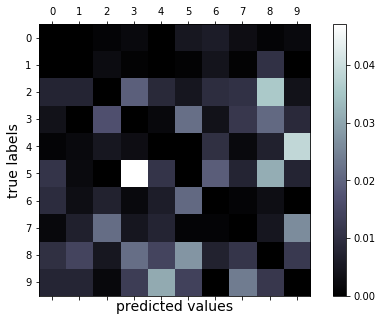

In [18]:
# normalize the diagnal cells so that they don't overpower the rest of the cells when visualized
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
cax = ax.matshow(norm_conf_mx, cmap=plt.cm.bone)
ticks = np.arange(0, 10, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(ticks)
ax.set_yticklabels(ticks)
fig.colorbar(cax)
plt.ylabel('true labels', fontsize=14)
plt.xlabel('predicted values', fontsize=14)
plt.savefig('conf.png')
plt.show()

## Deploy as web service

Once you've tested the model and are satisfied with the results, deploy the model as a web service hosted in ACI. 

To build the correct environment for ACI, provide the following:
* A scoring script to show how to use the model
* An environment file to show what packages need to be installed
* A configuration file to build the ACI
* The model you trained before

### Create scoring script

Create the scoring script, called score.py, used by the web service call to show how to use the model.

You must include two required functions into the scoring script:
* The `init()` function, which typically loads the model into a global object. This function is run only once when the Docker container is started. 

* The `run(input_data)` function uses the model to predict a value based on the input data. Inputs and outputs to the run typically use JSON for serialization and de-serialization, but other formats are supported.


In [19]:
%%writefile score.py
import json
import numpy as np
import os
import pickle
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression

from azureml.core.model import Model

def init():
    global model
    # retreive the path to the model file using the model name
    model_path = Model.get_model_path('sklearn_mnist')
    model = joblib.load(model_path)

def run(raw_data):
    data = np.array(json.loads(raw_data)['data'])
    # make prediction
    y_hat = model.predict(data)
    # you can return any data type as long as it is JSON-serializable
    return y_hat.tolist()

Writing score.py


### Create environment file

Next, create an environment file, called myenv.yml, that specifies all of the script's package dependencies. This file is used to ensure that all of those dependencies are installed in the Docker image. This model needs `scikit-learn` and `azureml-sdk`.

In [20]:
from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies()
myenv.add_conda_package("scikit-learn")

with open("myenv.yml","w") as f:
    f.write(myenv.serialize_to_string())

Review the content of the `myenv.yml` file.

In [21]:
with open("myenv.yml","r") as f:
    print(f.read())

# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
    # Required packages for AzureML execution, history, and data preparation.
  - azureml-defaults
- scikit-learn



### Create configuration file

Create a deployment configuration file and specify the number of CPUs and gigabyte of RAM needed for your ACI container. While it depends on your model, the default of 1 core and 1 gigabyte of RAM is usually sufficient for many models. If you feel you need more later, you would have to recreate the image and redeploy the service.

In [22]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={"data": "MNIST",  "method" : "sklearn"}, 
                                               description='Predict MNIST with sklearn')

### Deploy in ACI
Estimated time to complete: **about 7-8 minutes**

Configure the image and deploy. The following code goes through these steps:

1. Build an image using:
   * The scoring file (`score.py`)
   * The environment file (`myenv.yml`)
   * The model file
1. Register that image under the workspace. 
1. Send the image to the ACI container.
1. Start up a container in ACI using the image.
1. Get the web service HTTP endpoint.

In [23]:
%%time
from azureml.core.webservice import Webservice
from azureml.core.image import ContainerImage

# configure the image
image_config = ContainerImage.image_configuration(execution_script="score.py", 
                                                  runtime="python", 
                                                  conda_file="myenv.yml")

service = Webservice.deploy_from_model(workspace=ws,
                                       name='sklearn-mnist-svc',
                                       deployment_config=aciconfig,
                                       models=[model],
                                       image_config=image_config)

service.wait_for_deployment(show_output=True)

Creating image
Image creation operation finished for image sklearn-mnist-svc:1, operation "Succeeded"
Creating service
Running................
SucceededACI service creation operation finished, operation "Succeeded"
CPU times: user 4.08 s, sys: 220 ms, total: 4.3 s
Wall time: 6min


Get the scoring web service's HTTP endpoint, which accepts REST client calls. This endpoint can be shared with anyone who wants to test the web service or integrate it into an application.

In [24]:
print(service.scoring_uri)

http://23.101.137.78:80/score


## Test deployed service

Earlier you scored all the test data with the local version of the model. Now, you can test the deployed model with a random sample of 30 images from the test data.  

The following code goes through these steps:
1. Send the data as a JSON array to the web service hosted in ACI. 

1. Use the SDK's `run` API to invoke the service. You can also make raw calls using any HTTP tool such as curl.

1. Print the returned predictions and plot them along with the input images. Red font and inverse image (white on black) is used to highlight the misclassified samples. 

 Since the model accuracy is high, you might have to run the following code a few times before you can see a misclassified sample.

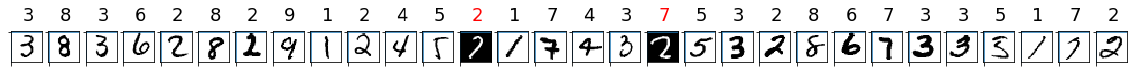

In [25]:
import json

# find 30 random samples from test set
n = 30
sample_indices = np.random.permutation(X_test.shape[0])[0:n]

test_samples = json.dumps({"data": X_test[sample_indices].tolist()})
test_samples = bytes(test_samples, encoding='utf8')

# predict using the deployed model
result = service.run(input_data=test_samples)

# compare actual value vs. the predicted values:
i = 0
plt.figure(figsize = (20, 1))

for s in sample_indices:
    plt.subplot(1, n, i + 1)
    plt.axhline('')
    plt.axvline('')
    
    # use different color for misclassified sample
    font_color = 'red' if y_test[s] != result[i] else 'black'
    clr_map = plt.cm.gray if y_test[s] != result[i] else plt.cm.Greys
    
    plt.text(x=10, y =-10, s=result[i], fontsize=18, color=font_color)
    plt.imshow(X_test[s].reshape(28, 28), cmap=clr_map)
    
    i = i + 1
plt.show()

You can also send raw HTTP request to test the web service.

In [26]:
import requests
import json

# send a random row from the test set to score
random_index = np.random.randint(0, len(X_test)-1)
input_data = "{\"data\": [" + str(list(X_test[random_index])) + "]}"

headers = {'Content-Type':'application/json'}

# for AKS deployment you'd need to the service key in the header as well
# api_key = service.get_key()
# headers = {'Content-Type':'application/json',  'Authorization':('Bearer '+ api_key)} 

resp = requests.post(service.scoring_uri, input_data, headers=headers)

print("POST to url", service.scoring_uri)
#print("input data:", input_data)
print("label:", y_test[random_index])
print("prediction:", resp.text)

POST to url http://23.101.137.78:80/score
label: 2
prediction: [2]


## Clean up resources

To keep the resource group and workspace for other tutorials and exploration, you can delete only the ACI deployment using this API call:

In [27]:
service.delete()


If you're not going to use what you've created here, delete the resources you just created with this quickstart so you don't incur any charges. In the Azure portal, select and delete your resource group. You can also keep the resource group, but delete a single workspace by displaying the workspace properties and selecting the Delete button.


## Next steps

In this Azure Machine Learning tutorial, you used Python to:

> * Set up your testing environment
> * Retrieve the model from your workspace
> * Test the model locally
> * Deploy the model to ACI
> * Test the deployed model
 
